## Libraries and functions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import time
import matplotlib.patches as mpatches
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import warnings
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, precision_recall_curve, average_precision_score, auc, roc_curve
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, SCORERS
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, LeaveOneOut

In [2]:
warnings.simplefilter("ignore")

In [3]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [4]:
# improve how pandas numbers are displayed
pd.set_option('display.float_format', lambda x: '%.4f' % x)
pd.set_option('display.max_columns', 25)
pd.set_option('display.max_rows', 50)

np.set_printoptions(suppress=True)

## Loading data

### Train data

In [5]:
%%time 
train_transactions=pd.read_csv('train_transaction.csv')
train_identity=pd.read_csv('train_identity.csv')
print('Train data set is loaded !')

Train data set is loaded !
Wall time: 12.9 s


In [6]:
train_transactions.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,...,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5000,W,13926,NaN,150.0000,discover,142.0000,credit,315.0000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0000,W,2755,404.0000,150.0000,mastercard,102.0000,credit,325.0000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0000,W,4663,490.0000,150.0000,visa,166.0000,debit,330.0000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0000,W,18132,567.0000,150.0000,mastercard,117.0000,debit,476.0000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0000,H,4497,514.0000,150.0000,mastercard,102.0000,credit,420.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


In [7]:
train_transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 394 entries, TransactionID to V339
dtypes: float64(376), int64(4), object(14)
memory usage: 1.7+ GB


In [8]:
train_identity.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,...,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0000,70787.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0000,...,NotFound,Android 7.0,samsung browser 6.2,32.0000,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0000,98945.0000,NaN,NaN,0.0000,-5.0000,NaN,NaN,NaN,NaN,100.0000,...,NotFound,iOS 11.1.2,mobile safari 11.0,32.0000,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0000,191631.0000,0.0000,0.0000,0.0000,0.0000,NaN,NaN,0.0000,0.0000,100.0000,...,Found,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0000,221832.0000,NaN,NaN,0.0000,-6.0000,NaN,NaN,NaN,NaN,100.0000,...,NotFound,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0000,7460.0000,0.0000,0.0000,1.0000,0.0000,NaN,NaN,0.0000,0.0000,100.0000,...,Found,Mac OS X 10_11_6,chrome 62.0,24.0000,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [9]:
train_identity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144233 entries, 0 to 144232
Data columns (total 41 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   TransactionID  144233 non-null  int64  
 1   id_01          144233 non-null  float64
 2   id_02          140872 non-null  float64
 3   id_03          66324 non-null   float64
 4   id_04          66324 non-null   float64
 5   id_05          136865 non-null  float64
 6   id_06          136865 non-null  float64
 7   id_07          5155 non-null    float64
 8   id_08          5155 non-null    float64
 9   id_09          74926 non-null   float64
 10  id_10          74926 non-null   float64
 11  id_11          140978 non-null  float64
 12  id_12          144233 non-null  object 
 13  id_13          127320 non-null  float64
 14  id_14          80044 non-null   float64
 15  id_15          140985 non-null  object 
 16  id_16          129340 non-null  object 
 17  id_17          139369 non-nul

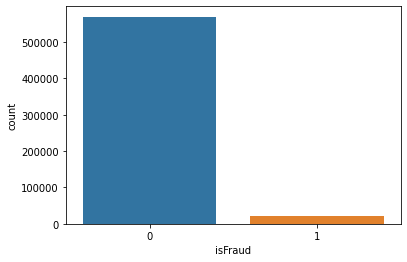

In [10]:
sns.countplot(x=train_transactions["isFraud"]);

There is clearly a class imbalace problem.

### Merging training data

In [11]:
train_df = train_transactions.merge(train_identity, how="left", on="TransactionID")
print('Train shape',train_df.shape)

print("Data set merged ")
del train_transactions, train_identity

Train shape (590540, 434)
Data set merged 


### Reducing training memory usage

In [12]:
%%time
train_df = reduce_mem_usage(train_df)

Mem. usage decreased to 650.48 Mb (66.8% reduction)
Wall time: 1min 3s


### Load test data

In [13]:
%%time 
test_transaction=pd.read_csv('test_transaction.csv')
test_identity=pd.read_csv('test_identity.csv')
sample_submission=pd.read_csv('sample_submission.csv')
print('Test data set is loaded !')

Test data set is loaded !
Wall time: 11.5 s


### Merging testing data

In [14]:
%%time
test_df = test_transaction.merge(test_identity, how="left", on="TransactionID")

print('Train shape',train_df.shape)

print("Data set merged ")

del test_transaction, test_identity

Train shape (590540, 434)
Data set merged 
Wall time: 4.67 s


### Reducing testing memory usage

In [15]:
%%time
test_df = reduce_mem_usage(test_df)

Mem. usage decreased to 565.37 Mb (66.3% reduction)
Wall time: 55.8 s


In [16]:
# fix columns names
test_df= test_df.rename(columns=lambda x:"_".join(x.split("-")))

# set TransactionID as index
train_df.set_index('TransactionID', inplace=True)
test_df.set_index('TransactionID', inplace=True)

## Replace missing values and use label encoder for categorical variables

In [17]:
%%time
nan_values = pd.DataFrame(train_df.isna().sum())
nan_values.columns = ['nan_sum']
nan_values = nan_values[nan_values.nan_sum != 0]

# NAN values percentage in the column
nan_values['all_values'] = len(train_df)
nan_values['percentage_of_nan'] = round((nan_values.nan_sum / nan_values.all_values *100),2)
nan_values = nan_values.sort_values(by='percentage_of_nan', ascending=False)
print(nan_values.shape)
nan_values.head(30)

(414, 3)
Wall time: 1.2 s


,nan_sum,all_values,percentage_of_nan
id_24,585793,590540,99.2000
id_07,585385,590540,99.1300
id_08,585385,590540,99.1300
id_21,585381,590540,99.1300
id_26,585377,590540,99.1300
id_25,585408,590540,99.1300
id_23,585371,590540,99.1200
id_27,585371,590540,99.1200
id_22,585371,590540,99.1200
dist2,552913,590540,93.6300


In [18]:
%%time

# Replace missing values with 0
train_df = train_df.fillna(0)
test_df = test_df.fillna(0)

Wall time: 3.96 s


In [28]:
%%time

# Label Encoding
for f in train_df.columns:
    if train_df[f].dtype=='object': 
        lbl = LabelEncoder()
        lbl.fit(list(train_df[f].values))
        train_df[f] = lbl.transform(list(train_df[f].values)) 

for f in test_df.columns:
    if test_df[f].dtype=='object': 
        lbl = LabelEncoder()
        lbl.fit(list(test_df[f].values))
        test_df[f] = lbl.transform(list(test_df[f].values))

Wall time: 87.4 ms


In [29]:
X_train, X_test, y_train, y_test = train_test_split(train_df.drop('isFraud', axis=1), train_df['isFraud'].astype('uint8'), test_size=.2, random_state=42, stratify=train_df['isFraud'].astype('uint8'))

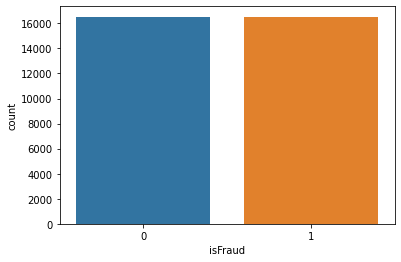

In [30]:
df_majority = X_train[y_train == 0]
df_minority = X_train[y_train == 1]
size_minor = len(df_minority)

y_majority = y_train[y_train == 0]
y_minority = y_train[y_train == 1]

# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                   replace=False,    # sample with replacement
                   n_samples=size_minor,    # to match majority class
                   random_state=42)  # reproducible results

X_down_train = pd.concat([df_minority, df_majority_downsampled])
# print(X_down_train.shape)

y_majority_downsampled = y_majority[df_majority_downsampled.index]
y_down_train = pd.concat([y_minority, y_majority_downsampled])
# y_down_train.value_counts()

sns.countplot(x = y_down_train);

In [31]:
# %%time
# std_scaler = preprocessing.StandardScaler()
# X_train_std = std_scaler.fit_transform(X_down_train)
# X_test_std = std_scaler.transform(X_test)

In [37]:
%%time
clf_rf_down = RandomForestClassifier(random_state=42)
model_rf_down = clf_rf_down.fit(X_down_train, y_down_train)
# y_pred = model_rf_down.predict(X_test)
y_prob = model_rf_down.predict_proba(X_test)[:, 1]
print(f'ROC-AUC score: {roc_auc_score(y_test, y_prob):.3f}')

ROC-AUC score: 0.924
Wall time: 14.4 s


## Randomized search

In [24]:
# %%time
# score = "roc_auc"
# tuned_parameters_rs = tuned_parameters = {'n_estimators': [30, 50, 100],
#                'max_features': ['auto'],
#                'min_samples_split': [3, 4, 5, 7],
#                'bootstrap': [False],
#                 }
# clf_rs = RandomizedSearchCV(model_rf_down, tuned_parameters_rs, scoring=score, n_iter=16)
# clf_rs.fit(X_res, y_res)
# y_pred = clf_rs.predict(X_test_std)
# print(f'Random Search F1: {roc_auc_score(y_true=y_test, y_pred=y_pred)}')
# print("Best parameters set found on training set:")
# print(clf_rs.best_params_)

In [25]:
# counter_before = Counter(y_train)
# smt = SMOTETomek(random_state=42)
# X_train_sm, y_train_sm = smt.fit_resample(X_train, y_train)

# print(f'Before: {counter_before}')
# print(f'After: {Counter(y_train_sm)}')

## Fit the model

In [38]:
predictions_rf = clf_rf_down.predict_proba(test_df)[:,1]
submission = pd.DataFrame({'TransactionID':test_df.index,'isFraud':predictions_rf})
submission["TransactionID"]=submission["TransactionID"].astype(int)
submission.head()

,TransactionID,isFraud
0,3663549,0.1700
1,3663550,0.1100
2,3663551,0.3300
3,3663552,0.1800
4,3663553,0.1800


In [39]:
filename = 'rf_model_submission.csv'
submission.to_csv(filename, index=False)
print(f'Saved file: {filename}')

Saved file: rf_model_submission.csv
